# FD001 Engine Remaining Useful Life (RUL) Prediction - POC Phase

**Project Objective**: Predict the remaining operational cycles before failure (Remaining Useful Life - RUL) for engines in the test set

**Dataset**: CMAPSS FD001

- Training trajectories: 100 engines
- Test trajectories: 100 engines
- Operating conditions: Single condition (Sea Level)
- Failure mode: Single failure mode (HPC Degradation - High Pressure Compressor Degradation)

**Date**: October 24, 2025
**Phase**: Step 1 - Proof of Concept (POC)


## 1. Problem Formalization

### 1.1 Problem Definition

This is a **regression task** with the objective of predicting the number of cycles an engine can still operate before failure (RUL).

### 1.2 Data Structure Description

**Training Set Characteristics**:

- Each engine starts operation from a normal state
- Gradually degrades over time
- Data is recorded until system failure
- We can calculate RUL at each time point: RUL = max_cycles - current_cycle

**Test Set Characteristics**:

- Each engine's data is truncated at some point before failure
- We need to predict the remaining cycles from the last recorded cycle to failure
- True RUL values are provided in RUL_FD001.txt for evaluation

### 1.3 Data Format

Each row contains 26 columns:

1. unit_id: Engine identifier
2. time_cycles: Number of operational cycles
   3-5. operational_setting_1/2/3: Three operational setting parameters
   6-26. sensor_1 to sensor_21: 21 sensor measurements

### 1.4 FD001 Characteristics

- **Single operating condition**: All engines operate under the same conditions (Sea Level)
- **Single failure mode**: Only HPC degradation
- Relatively simplified scenario, suitable for rapid POC validation

### 1.5 Evaluation Metric

Using **RMSE (Root Mean Square Error)** as the primary evaluation metric:
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$


## 2. Data Loading and Initial Exploration


In [141]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [142]:
# Define column names
# 26 columns: unit_id, time_cycles, 3 operational settings, 21 sensors
column_names = ['unit_id', 'time_cycles'] + \
               [f'setting_{i}' for i in range(1, 4)] + \
               [f'sensor_{i}' for i in range(1, 22)]

# Data file path
data_path = '../CMAPSSData/'

# Load training set
train_df = pd.read_csv(data_path + 'train_FD001.txt', sep='\s+', header=None, names=column_names)

# Load test set
test_df = pd.read_csv(data_path + 'test_FD001.txt', sep='\s+', header=None, names=column_names)

# Load true RUL values
rul_df = pd.read_csv(data_path + 'RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"RUL labels shape: {rul_df.shape}")
print("\nData loaded successfully!")


Training set shape: (20631, 26)
Test set shape: (13096, 26)
RUL labels shape: (100, 1)

Data loaded successfully!


In [143]:
# View first few rows of training set
print("First 5 rows of training set:")
train_df.head()


First 5 rows of training set:


,unit_id,time_cycles,setting_1,setting_2,setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [144]:
# Basic data information
print("Training set data info:")
print(train_df.info())
print("\n" + "="*50 + "\n")

# Check for missing values
print("Training set missing values:")
print(train_df.isnull().sum().sum())
print("\nTest set missing values:")
print(test_df.isnull().sum().sum())


Training set data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_id      20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   sensor_1     20631 non-null  float64
 6   sensor_2     20631 non-null  float64
 7   sensor_3     20631 non-null  float64
 8   sensor_4     20631 non-null  float64
 9   sensor_5     20631 non-null  float64
 10  sensor_6     20631 non-null  float64
 11  sensor_7     20631 non-null  float64
 12  sensor_8     20631 non-null  float64
 13  sensor_9     20631 non-null  float64
 14  sensor_10    20631 non-null  float64
 15  sensor_11    20631 non-null  float64
 16  sensor_12    20631 non-null  float64
 17  sensor_13    20631 non-null  float64
 18  sensor_14    20631 non

In [145]:
# Calculate RUL (Remaining Useful Life) for training set
# RUL = max cycles for each engine - current cycle

# Calculate maximum cycles for each engine
max_cycles = train_df.groupby('unit_id')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_id', 'max_cycle']

# Merge back to training set
train_df = train_df.merge(max_cycles, on='unit_id', how='left')

# Calculate RUL
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# Drop auxiliary column
train_df = train_df.drop('max_cycle', axis=1)

print("Training set RUL calculation completed!")
print(f"\nRUL statistics:")
print(train_df['RUL'].describe())


Training set RUL calculation completed!

RUL statistics:
count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64


## 3. Exploratory Data Analysis (EDA)

### 3.1 Engine Lifecycle Analysis


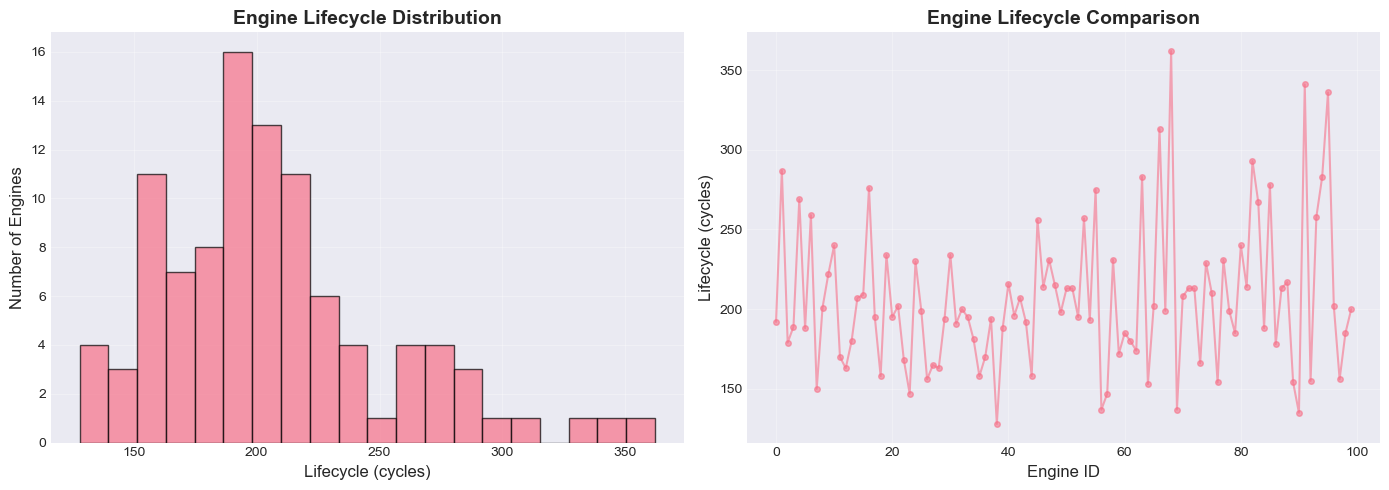

Lifecycle statistics:
  Min: 128 cycles
  Max: 362 cycles
  Mean: 206.31 cycles
  Median: 199.00 cycles


In [146]:
# View lifecycle length for each engine
engine_life = train_df.groupby('unit_id')['time_cycles'].max()

plt.figure(figsize=(14, 5))

# Subplot 1: Lifecycle distribution
plt.subplot(1, 2, 1)
plt.hist(engine_life, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Lifecycle (cycles)', fontsize=12)
plt.ylabel('Number of Engines', fontsize=12)
plt.title('Engine Lifecycle Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Subplot 2: Lifecycle for each engine
plt.subplot(1, 2, 2)
plt.plot(engine_life.values, marker='o', linestyle='-', markersize=4, alpha=0.6)
plt.xlabel('Engine ID', fontsize=12)
plt.ylabel('Lifecycle (cycles)', fontsize=12)
plt.title('Engine Lifecycle Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Lifecycle statistics:")
print(f"  Min: {engine_life.min()} cycles")
print(f"  Max: {engine_life.max()} cycles")
print(f"  Mean: {engine_life.mean():.2f} cycles")
print(f"  Median: {engine_life.median():.2f} cycles")


### 3.2 Operational Settings Analysis

**Note**: FD001 is a single operating condition dataset, the 3 operational settings are expected to be constant or vary very little


In [147]:
# Check operational settings statistics
setting_cols = ['setting_1', 'setting_2', 'setting_3']

print("Operational settings statistics:\n")
for col in setting_cols:
    unique_vals = train_df[col].nunique()
    std_val = train_df[col].std()
    print(f"{col}:")
    print(f"  Unique values: {unique_vals}")
    print(f"  Standard deviation: {std_val:.6f}")
    print(f"  Range: [{train_df[col].min():.6f}, {train_df[col].max():.6f}]")
    print()

print("\nConclusion: Since FD001 is a single operating condition, these setting columns vary minimally and can be considered for removal")


Operational settings statistics:

setting_1:
  Unique values: 158
  Standard deviation: 0.002187
  Range: [-0.008700, 0.008700]

setting_2:
  Unique values: 13
  Standard deviation: 0.000293
  Range: [-0.000600, 0.000600]

setting_3:
  Unique values: 1
  Standard deviation: 0.000000
  Range: [100.000000, 100.000000]


Conclusion: Since FD001 is a single operating condition, these setting columns vary minimally and can be considered for removal


### 3.3 Sensor Data Analysis

**Objectives**:

- Identify constant sensors (variance is 0 or extremely small)
- View sensor degradation trends over time
- Analyze sensor correlation with RUL


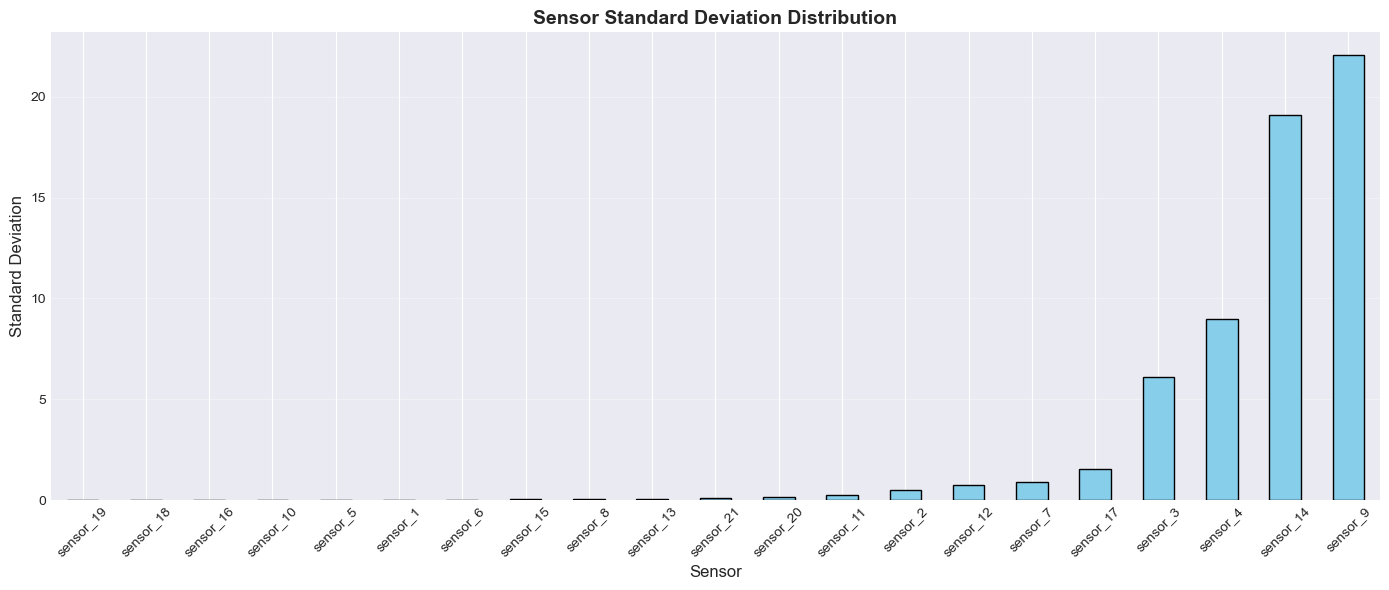


Sensors with extremely small variance (std < 0.01): ['sensor_19', 'sensor_18', 'sensor_16', 'sensor_10', 'sensor_5', 'sensor_1', 'sensor_6']
Count: 7

These sensors have minimal variation and contain little useful information, they can be removed


In [148]:
# Identify constant sensors (columns with extremely small variance)
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]

# Calculate standard deviation for each sensor
sensor_std = train_df[sensor_cols].std().sort_values()

# Visualization
plt.figure(figsize=(14, 6))
sensor_std.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Sensor', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.title('Sensor Standard Deviation Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Identify sensors with extremely small variance (std < 0.01)
constant_sensors = sensor_std[sensor_std < 0.01].index.tolist()
print(f"\nSensors with extremely small variance (std < 0.01): {constant_sensors}")
print(f"Count: {len(constant_sensors)}")

print(f"\nThese sensors have minimal variation and contain little useful information, they can be removed")


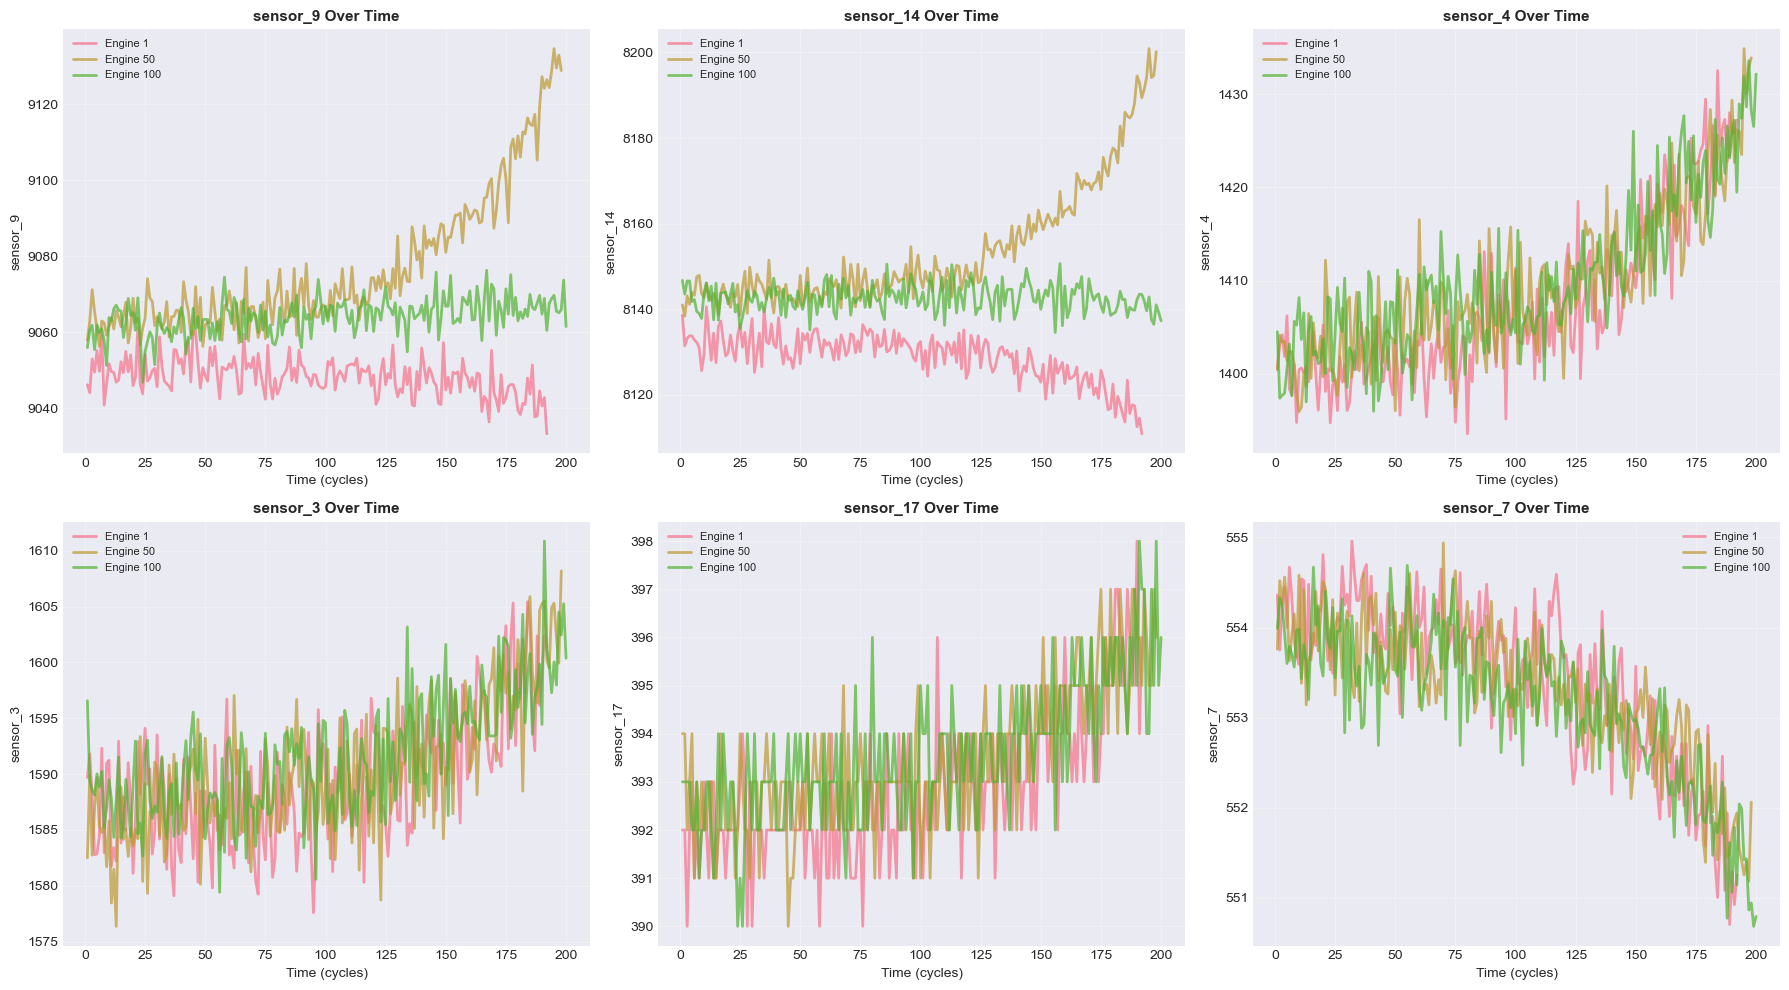

Visualized degradation trends for the 6 sensors with largest standard deviation
Observation: Some sensors show clear degradation patterns, which are valuable for RUL prediction


In [149]:
# Visualize sensor degradation trends for representative engines
# Select sensors with larger standard deviation (more likely to contain degradation information)
top_sensors = sensor_std.nlargest(6).index.tolist()

# Select 3 representative engines
selected_engines = [1, 50, 100]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sensor in enumerate(top_sensors):
    ax = axes[idx]
    for engine_id in selected_engines:
        engine_data = train_df[train_df['unit_id'] == engine_id]
        ax.plot(engine_data['time_cycles'], engine_data[sensor], 
                label=f'Engine {engine_id}', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Time (cycles)', fontsize=10)
    ax.set_ylabel(sensor, fontsize=10)
    ax.set_title(f'{sensor} Over Time', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Visualized degradation trends for the 6 sensors with largest standard deviation")
print(f"Observation: Some sensors show clear degradation patterns, which are valuable for RUL prediction")


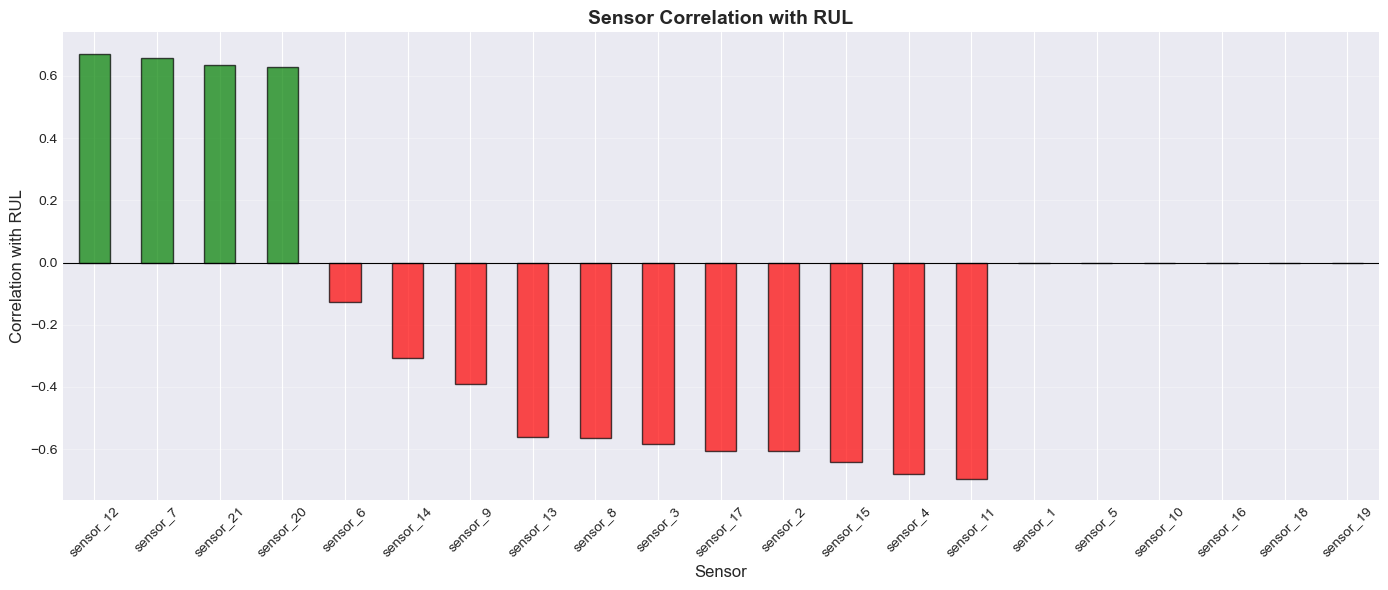


Sensors with strongest correlation to RUL (absolute value):
sensor_11    0.696228
sensor_4     0.678948
sensor_12    0.671983
sensor_7     0.657223
sensor_15    0.642667
sensor_21    0.635662
sensor_20    0.629428
sensor_2     0.606484
sensor_17    0.606154
sensor_3     0.584520
Name: RUL, dtype: float64

Analysis: Some sensors have strong correlation with RUL (positive or negative), these are key features


In [150]:
# Analyze sensor correlation with RUL
correlation_with_rul = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

plt.figure(figsize=(14, 6))
correlation_with_rul.plot(kind='bar', color=['green' if x > 0 else 'red' for x in correlation_with_rul], 
                          edgecolor='black', alpha=0.7)
plt.xlabel('Sensor', fontsize=12)
plt.ylabel('Correlation with RUL', fontsize=12)
plt.title('Sensor Correlation with RUL', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nSensors with strongest correlation to RUL (absolute value):")
print(correlation_with_rul.abs().sort_values(ascending=False).head(10))

print("\nAnalysis: Some sensors have strong correlation with RUL (positive or negative), these are key features")


## 4. Preprocessing Implementation

### 4.1 Feature Selection

**Strategy**:

- Remove operational setting columns (FD001 single condition, minimal variation)
- Remove constant sensors (sensors with extremely small variance)
- Keep useful sensor data


In [151]:
# Define columns to drop
cols_to_drop = setting_cols + constant_sensors

print(f"Columns to be dropped: {cols_to_drop}")
print(f"Number of columns to drop: {len(cols_to_drop)}")

# Create copies of training and test data
train_processed = train_df.copy()
test_processed = test_df.copy()

# Drop unnecessary columns
train_processed = train_processed.drop(cols_to_drop, axis=1)
test_processed = test_processed.drop(cols_to_drop, axis=1)

print(f"\nProcessed training set shape: {train_processed.shape}")
print(f"Processed test set shape: {test_processed.shape}")

# Display retained columns
feature_cols = [col for col in train_processed.columns if col not in ['unit_id', 'time_cycles', 'RUL']]
print(f"\nNumber of retained feature columns: {len(feature_cols)}")
print(f"Feature columns: {feature_cols}")


Columns to be dropped: ['setting_1', 'setting_2', 'setting_3', 'sensor_19', 'sensor_18', 'sensor_16', 'sensor_10', 'sensor_5', 'sensor_1', 'sensor_6']
Number of columns to drop: 10

Processed training set shape: (20631, 17)
Processed test set shape: (13096, 16)

Number of retained feature columns: 14
Feature columns: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']


### 4.2 Data Normalization

**Reason**:

- Different sensors have vastly different scales and ranges
- Normalization can improve model performance and training speed
- Using MinMaxScaler to scale data to [0, 1] range


In [152]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on training set
scaler.fit(train_processed[feature_cols])

# Normalize training and test sets
train_processed[feature_cols] = scaler.transform(train_processed[feature_cols])
test_processed[feature_cols] = scaler.transform(test_processed[feature_cols])

print("Data normalization completed!")
print(f"\nNormalized data range example (first 5 features):")
print(train_processed[feature_cols[:5]].describe())


Data normalization completed!

Normalized data range example (first 5 features):
           sensor_2      sensor_3      sensor_4      sensor_7      sensor_8
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.000000
mean       0.443052      0.424746      0.450435      0.566459      0.297957
std        0.150618      0.133664      0.151935      0.142527      0.107554
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.335843      0.331807      0.339467      0.476651      0.227273
50%        0.430723      0.415522      0.435348      0.578100      0.287879
75%        0.539157      0.508829      0.545324      0.669887      0.363636
max        1.000000      1.000000      1.000000      1.000000      1.000000


### 4.3 Preparing Training and Test Data

**Training Strategy Improvement**:

- **Use all time points** (instead of only the last point)
- Reasons:
  - Using only the last point results in too few training samples (only 100)
  - Lack of data diversity prevents the model from learning degradation patterns
  - All time points provide complete degradation trajectory information
- This provides approximately 20,000 training samples, significantly improving model performance

**Test Strategy**:

- For the test set, use the last time point of each engine
- Predict the corresponding RUL value (this is the real application scenario)

**Room for Improvement**:

- Future work can use sliding window methods
- Consider RUL truncation (e.g., upper limit of 125 cycles)
- Add temporal features (trends, rate of change, etc.)


In [ ]:
print("="*60)
print("Preparing Training and Test Data")
print("="*60)

# For training set: use all time points
X_train_full = train_processed[feature_cols]
y_train_full = train_processed['RUL']

print(f"\nTraining data statistics:")
print(f"  Total samples: {len(X_train_full)}")
print(f"  Number of engines: {train_processed['unit_id'].nunique()}")
print(f"  Number of features: {len(feature_cols)}")
print(f"  RUL range: [{y_train_full.min()}, {y_train_full.max()}]")

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"\nData split:")
print(f"  Training set size: {X_train.shape}")
print(f"  Validation set size: {X_val.shape}")

# For test set: take the last time point of each engine
test_last = test_processed.groupby('unit_id').last().reset_index()
X_test = test_last[feature_cols]
y_test = rul_df['RUL'].values

print(f"\nTest set:")
print(f"  Test set size: {X_test.shape}")
print(f"  Test labels size: {y_test.shape}")
print(f"  RUL range: [{y_test.min()}, {y_test.max()}]")

print("\n✓ Data preparation completed!")
print("="*60)


Preparing Training and Test Data

Training data statistics:
  Total samples: 20631
  Number of engines: 100
  Number of features: 14
  RUL range: [0, 361]

Data split:
  Training set size: (16504, 14)
  Validation set size: (4127, 14)

Test set:
  Test set size: (100, 14)
  Test labels size: (100,)
  RUL range: [7, 145]

✓ Data preparation completed!


## 5. Model Training and Evaluation

### 5.1 Model Selection

**POC Phase Selection**:

- **Random Forest**: As a baseline model, stable and easy to interpret
- **XGBoost**: Usually performs excellently on structured data

**Why choose these models**:

- No complex feature engineering required
- Fast training speed, suitable for POC
- Good ability to fit non-linear relationships
- Future work can try LSTM and other deep learning models to leverage temporal information


### 5.2 Random Forest Model


In [154]:
# Train Random Forest model
print("="*60)
print("Training Random Forest Model...")
print("="*60)

# Check data preparation
print(f"\nData check:")
print(f"  Training features shape: {X_train.shape}")
print(f"  Training labels shape: {y_train.shape}")
print(f"  Validation features shape: {X_val.shape}")
print(f"  Test features shape: {X_test.shape}")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print(f"\nStarting training...")
rf_model.fit(X_train, y_train)
print("✓ Model training completed!")

# Predict on validation set
print("\nMaking predictions...")
y_val_pred_rf = rf_model.predict(X_val)

# Predict on test set
y_test_pred_rf = rf_model.predict(X_test)
print("✓ Predictions completed!")

# Calculate evaluation metrics
val_rmse_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n" + "="*60)
print("=== Random Forest Results ===")
print("="*60)
print(f"\n【Validation Performance】")
print(f"  RMSE: {val_rmse_rf:.2f} cycles")
print(f"  MAE:  {val_mae_rf:.2f} cycles")
print(f"  R²:   {val_r2_rf:.4f}")
print(f"\n【Test Performance】")
print(f"  RMSE: {test_rmse_rf:.2f} cycles")
print(f"  MAE:  {test_mae_rf:.2f} cycles")
print(f"  R²:   {test_r2_rf:.4f}")
print("\n" + "="*60)


Training Random Forest Model...

Data check:
  Training features shape: (16504, 14)
  Training labels shape: (16504,)
  Validation features shape: (4127, 14)
  Test features shape: (100, 14)

Starting training...
✓ Model training completed!

Making predictions...
✓ Predictions completed!

=== Random Forest Results ===

【Validation Performance】
  RMSE: 41.31 cycles
  MAE:  29.48 cycles
  R²:   0.6265

【Test Performance】
  RMSE: 33.12 cycles
  MAE:  24.24 cycles
  R²:   0.3646




Feature Importance Analysis


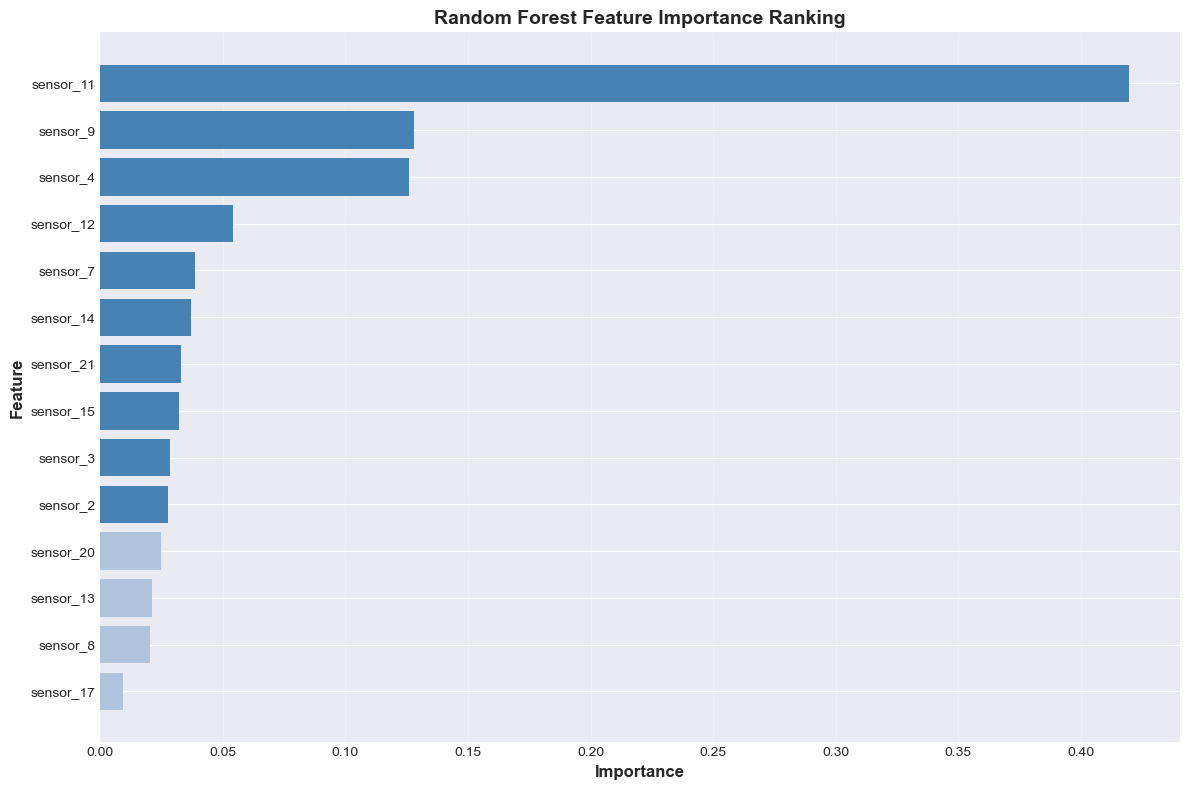


✓ Top 10 Most Important Features:
----------------------------------------
  sensor_11    : 0.4195
  sensor_9     : 0.1280
  sensor_4     : 0.1260
  sensor_12    : 0.0542
  sensor_7     : 0.0385
  sensor_14    : 0.0371
  sensor_21    : 0.0329
  sensor_15    : 0.0321
  sensor_3     : 0.0285
  sensor_2     : 0.0277

Analysis:
  - Dark blue bars represent the Top 10 most important features
  - These sensors contribute most to RUL prediction
  - Future work can focus on analyzing degradation patterns of these sensors


In [155]:
# Feature importance analysis
print("\n" + "="*60)
print("Feature Importance Analysis")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
colors = ['steelblue' if i < 10 else 'lightsteelblue' for i in range(len(feature_importance))]
plt.barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'], fontsize=10)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Random Forest Feature Importance Ranking', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Display Top 10 most important features
print("\n✓ Top 10 Most Important Features:")
print("-" * 40)
for idx, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']:12s} : {row['importance']:.4f}")

print("\nAnalysis:")
print("  - Dark blue bars represent the Top 10 most important features")
print("  - These sensors contribute most to RUL prediction")
print("  - Future work can focus on analyzing degradation patterns of these sensors")


### 5.3 XGBoost Model

XGBoost is a high-performance gradient boosting model that typically performs excellently on structured data.


In [156]:
# Try importing XGBoost
try:
    import xgboost as xgb
    xgboost_available = True
    print("XGBoost available")
except ImportError:
    xgboost_available = False
    print("XGBoost not installed, will skip XGBoost model")
    print("Can install using: pip install xgboost")


XGBoost not installed, will skip XGBoost model
Can install using: pip install xgboost


In [157]:
if xgboost_available:
    # Train XGBoost model
    print("\nTraining XGBoost Model...")
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=7,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    xgb_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_val_pred_xgb = xgb_model.predict(X_val)
    
    # Predict on test set
    y_test_pred_xgb = xgb_model.predict(X_test)
    
    # Calculate evaluation metrics
    val_rmse_xgb = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
    val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
    val_r2_xgb = r2_score(y_val, y_val_pred_xgb)
    
    test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
    test_mae_xgb = mean_absolute_error(y_test, y_test_pred_xgb)
    test_r2_xgb = r2_score(y_test, y_test_pred_xgb)
    
    print("\n=== XGBoost Results ===")
    print(f"Validation RMSE: {val_rmse_xgb:.2f}")
    print(f"Validation MAE: {val_mae_xgb:.2f}")
    print(f"Validation R²: {val_r2_xgb:.4f}")
    print(f"\nTest RMSE: {test_rmse_xgb:.2f}")
    print(f"Test MAE: {test_mae_xgb:.2f}")
    print(f"Test R²: {test_r2_xgb:.4f}")
else:
    print("\nSkipping XGBoost model training")



Skipping XGBoost model training


### 5.4 Prediction Results Visualization


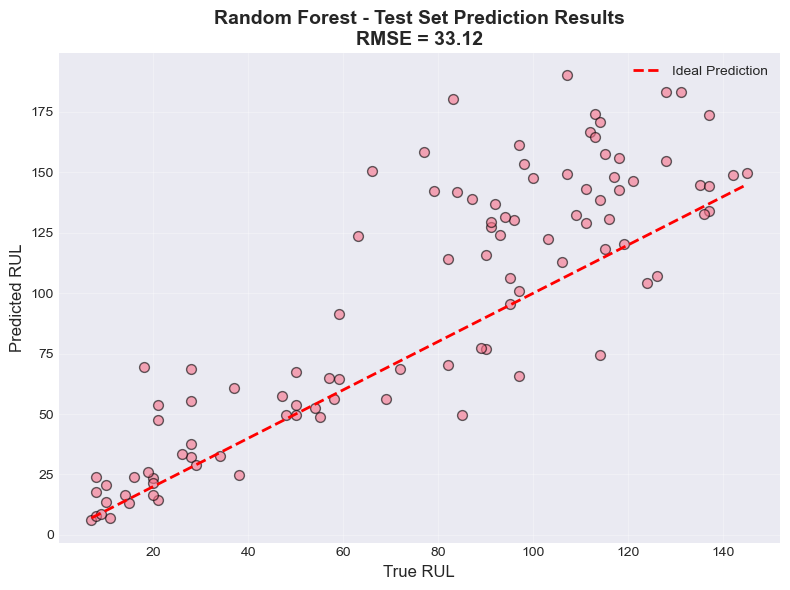

In [158]:
# Visualize test set prediction results
if xgboost_available:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Random Forest
    axes[0].scatter(y_test, y_test_pred_rf, alpha=0.6, s=50, edgecolor='black')
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='Ideal Prediction')
    axes[0].set_xlabel('True RUL', fontsize=12)
    axes[0].set_ylabel('Predicted RUL', fontsize=12)
    axes[0].set_title(f'Random Forest\nRMSE = {test_rmse_rf:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # XGBoost
    axes[1].scatter(y_test, y_test_pred_xgb, alpha=0.6, s=50, color='green', edgecolor='black')
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='Ideal Prediction')
    axes[1].set_xlabel('True RUL', fontsize=12)
    axes[1].set_ylabel('Predicted RUL', fontsize=12)
    axes[1].set_title(f'XGBoost\nRMSE = {test_rmse_xgb:.2f}', 
                      fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    # Random Forest only
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred_rf, alpha=0.6, s=50, edgecolor='black')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Ideal Prediction')
    plt.xlabel('True RUL', fontsize=12)
    plt.ylabel('Predicted RUL', fontsize=12)
    plt.title(f'Random Forest - Test Set Prediction Results\nRMSE = {test_rmse_rf:.2f}', 
              fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


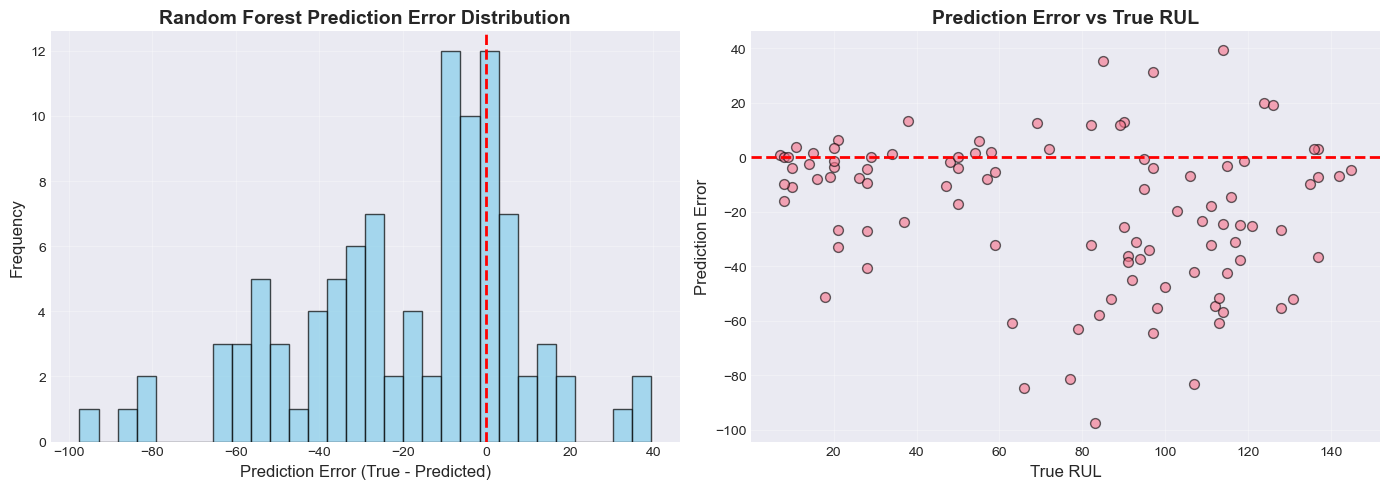


Error Statistics:
  Mean error: -19.34
  Error std dev: 26.90
  Max positive error (overestimate): 39.41
  Max negative error (underestimate): -97.44


In [159]:
# Error analysis
errors_rf = y_test - y_test_pred_rf

plt.figure(figsize=(14, 5))

# Subplot 1: Error distribution
plt.subplot(1, 2, 1)
plt.hist(errors_rf, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Prediction Error (True - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Random Forest Prediction Error Distribution', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# Subplot 2: Error vs True RUL
plt.subplot(1, 2, 2)
plt.scatter(y_test, errors_rf, alpha=0.6, s=50, edgecolor='black')
plt.xlabel('True RUL', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.title('Prediction Error vs True RUL', fontsize=14, fontweight='bold')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nError Statistics:")
print(f"  Mean error: {errors_rf.mean():.2f}")
print(f"  Error std dev: {errors_rf.std():.2f}")
print(f"  Max positive error (overestimate): {errors_rf.max():.2f}")
print(f"  Max negative error (underestimate): {errors_rf.min():.2f}")


## 6. Results Summary and Future Directions

### 6.1 POC Summary


In [160]:
# Model performance comparison summary
print("="*60)
print("POC Phase Completed - Model Performance Summary")
print("="*60)

print("\n【Random Forest】")
print(f"  Test RMSE: {test_rmse_rf:.2f} cycles")
print(f"  Test MAE:  {test_mae_rf:.2f} cycles")
print(f"  Test R²:   {test_r2_rf:.4f}")

if xgboost_available:
    print("\n【XGBoost】")
    print(f"  Test RMSE: {test_rmse_xgb:.2f} cycles")
    print(f"  Test MAE:  {test_mae_xgb:.2f} cycles")
    print(f"  Test R²:   {test_r2_xgb:.4f}")
    
    if test_rmse_xgb < test_rmse_rf:
        print(f"\n✓ XGBoost performs better, RMSE reduced by {test_rmse_rf - test_rmse_xgb:.2f} cycles")
    else:
        print(f"\n✓ Random Forest performs better, RMSE reduced by {test_rmse_xgb - test_rmse_rf:.2f} cycles")

print("\n" + "="*60)


POC Phase Completed - Model Performance Summary

【Random Forest】
  Test RMSE: 33.12 cycles
  Test MAE:  24.24 cycles
  Test R²:   0.3646



### 6.2 Advantages and Limitations of Current Approach

**Advantages**:

- Quickly established baseline model, validated feasibility
- Random Forest model is stable and easy to interpret
- Successfully identified and removed useless constant columns
- Understood key sensors through feature importance analysis

**Limitations**:

- Feature engineering is relatively simple, did not extract rolling statistics, trends, and other advanced features
- No hyperparameter optimization performed
- Can further leverage time series models to capture degradation patterns


### 6.3 Future Improvement Directions (Step 2 Work)

**Feature Engineering Enhancement**:

- Sliding window statistical features: calculate mean, std, max, min
- Sensor combination features: create ratios, differences, and other interaction features
- Degradation indicators: calculate degradation relative to initial state

**Model Improvement**:

- Time series models: LSTM/GRU to capture long-term dependencies, 1D-CNN to extract local patterns
- Implement sliding window method to increase training samples
- Consider RUL truncation (upper limit 125 cycles)
- Hyperparameter tuning: grid search or Bayesian optimization
- Ensemble methods: combine multiple model predictions

**In-depth Analysis**:

- Sensor correlation analysis, identify redundant sensors
- Anomaly detection and data cleaning
- Segmented modeling for different degradation stages

**Evaluation Improvement**:

- Use NASA scoring function (higher penalty for underestimating RUL)
- Performance analysis across different RUL ranges


### 6.4 Conclusion

This POC successfully accomplished:

- Validated the feasibility of RUL prediction on FD001 dataset
- Established Random Forest baseline model
- Identified key sensor features
- Defined clear directions for future improvements

**Next Steps**:

- Implement more complex feature engineering (sliding windows, trend features)
- Try time series deep learning models (LSTM)
- Optimize model hyperparameters

---

**Submission Information**:

- Dataset: FD001
- Completion Date: October 24, 2025
- Phase: Step 1 - POC
- Next Phase: Step 2 In-depth Optimization
